<a href="https://colab.research.google.com/github/Benjamin-morel/TensorFlow/blob/main/05_transfert_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


# **Machine Learning Model: image classification with transfert learning**

| | |
|------|------|
| Filename | 05_transfert_learning.ipynb |
| Author(s) | Benjamin Morel (benjaminmorel27@gmail.com) |
| Date | December 19, 2024 |
| Aim(s) | Classify images of flowers with a pre-trained network |
| Dataset(s) | Flower API Google database [[1]](https://www.kaggle.com/datasets/abdelrahmanatef01/flowers-dataset-for-image-classification)|
| Version | Python 3.10.12 - TensorFlow 2.17.1 |


<br> **!!Read before running!!** <br>
1. Fill in the inputs
2. GPU execution is recommanded if `training_phase = "Yes"`
3. Run all and read comments

---

#### **Motivation**

The flower Google API database is again used for this model, which uses a pre-trained model (MobileNet V2). The aim is to use this complex model to extract complex features from flower images. This is called transfer learning.

#### **Outline**
* retrieve data from a .csv
* cleaning data and pre-processing
* model definition and training
* comparison & predictions
* references




---


## **0. Input section**





The model has already been trained and the user can choose to used a pre-trained model (No) or to repeat the training phase (Yes). Using a pre-trained model saves time, computer resources and CO2 emissions.

In [1]:
training_phase = 'No'

---


## **1. Python librairies & display utilities**

In [2]:
# @title 1.1. Python librairies [RUN ME]

""" math """
import numpy as np # linear algebra
import sklearn.metrics # scores and evaluation metrics

""" file opening and data"""
import os # miscellaneous operating system interfaces
from pandas import DataFrame # data manipulation tool

""" ML models """
import tensorflow as tf # framework for ML/DL
from tensorflow import keras # API used to build model in TensorFlow

""" display """
from PIL import Image # image processing capabilities
import matplotlib.pyplot as plt # graphing package

In [3]:
# @title 1.2. Import Github files [RUN ME]

"""Clone the Github repertory TensorFlow and imports the files required (see section 3.2)"""

def get_github_files():
  !git clone https://github.com/Benjamin-morel/TensorFlow.git TensorFlow_duplicata
  path_training_curves_1 = 'TensorFlow_duplicata/99_pre_trained_models/05_transfert_learning/training_curves_1.png'
  path_training_curves_2 = 'TensorFlow_duplicata/99_pre_trained_models/05_transfert_learning/training_curves_2.png'
  path_model = 'TensorFlow_duplicata/99_pre_trained_models/05_transfert_learning/05_transfert_learning.keras'
  path_model_fine_tune = 'TensorFlow_duplicata/99_pre_trained_models/05_transfert_learning/05_transfert_learning_FT.keras'
  training_curves_1 = Image.open(path_training_curves_1)
  training_curves_2 = Image.open(path_training_curves_2)
  model = keras.models.load_model(path_model)
  model_fine_tune = keras.models.load_model(path_model_fine_tune)
  !rm -rf TensorFlow_duplicata/
  return training_curves_1, training_curves_2, model, model_fine_tune

"""Clone the Github repertory TensorFlow and imports the photos required (see section 3.2)"""

def get_github_photo():
  !git clone https://github.com/Benjamin-morel/TensorFlow.git TensorFlow_duplicata
  path_tulip = "TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/tulip.jpeg"
  path_rose = "TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/rose.jpeg"
  path_daisy = "TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/daisy.jpeg"
  path_sunflowers = "TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/sunflowers.jpeg"
  path_bouquet = "TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/bouquet.jpeg"
  tulip = Image.open(path_tulip)
  rose = Image.open(path_rose)
  daisy = Image.open(path_daisy)
  sunflowers = Image.open(path_sunflowers)
  bouquet = Image.open(path_bouquet)
  !rm -rf TensorFlow_duplicata/
  return tulip, rose, daisy, sunflowers, bouquet

In [4]:
# @title 1.3. Figure plots [RUN ME]

"""Plot a sample image with the label as title (see section 2 and section 5.1)"""
def plot_images(image, *label):
  plt.imshow(image)
  plt.title("%s" %label)
  image = plt.axis("off")
  return image

"""Plot distribution of dataset labels (see section 2.2)"""
def plot_distribution(dataset, class_names):
    labels = tf.concat([y for x, y in dataset], axis=0) # collect dataset labels only
    plt.hist(labels, bins=[0,0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4,4.5], align='mid')
    plt.xlabel("Flower name"), plt.ylabel("Total"), plt.title("Dataset label distribution"), plt.xticks([0.25, 1.25, 2.25, 3.25, 4.25], class_names)
    plt.show()

"""Plot training curves (see section 3.2)"""
def plot_evolution(history):
  loss_train, loss_val = history[0], history[2]
  acc_train, acc_val = history[1], history[3]
  epochs = range(1, len(acc_train) + 1)

  fig = plt.subplot(2,1,1)
  plt.plot(epochs, loss_train, label='Training', color='blue')
  plt.plot(epochs, loss_val, label='Validation', color='orange')
  plt.legend(loc='best', fontsize=10)
  plt.grid(True, linestyle='--', alpha=0.6), plt.ylabel('Loss', fontsize=12)

  plt.subplot(2,1,2)
  plt.plot(epochs, acc_train, color='blue')
  plt.plot(epochs, acc_val, color='orange')
  plt.xlabel('Epochs', fontsize=12), plt.ylabel('Accuracy', fontsize=12)
  plt.grid(True, linestyle='--', alpha=0.6)

"""Plot evaluation graphs (see section 4.1 and section 5.4)"""
def plot_evaluation(test_dataset, predictions, labels):
    actuals = tf.concat([y for x, y in test_dataset], axis=0)
    predicted_labels = np.argmax(predictions, axis=1)

    plt.figure(figsize=(12,5))

    confusion_mat = tf.math.confusion_matrix(actuals,predicted_labels) # columns = prediction labels / rows = real labels
    plt.imshow(confusion_mat)

    for i in range(confusion_mat.shape[0]): # annotation in each cnfusion matrix cell
        for j in range(confusion_mat.shape[1]):
            plt.text(x=j, y=i,s=int(confusion_mat[i, j]), va='center', ha='center', size='large')
    plt.xlabel("Predictions"), plt.ylabel("Actuals"), plt.title("Confusion matrix of the test set"), plt.xticks(np.arange(len(labels)), labels), plt.yticks(np.arange(len(labels)), labels)

    # Metrics info
    accuracy = sklearn.metrics.accuracy_score(actuals, predicted_labels)
    recall = sklearn.metrics.recall_score(actuals, predicted_labels, average='weighted')
    F1_score = sklearn.metrics.f1_score(actuals, predicted_labels, average='weighted')

    print("############################")
    print("Evaluation on the test set: ")
    print("############################")
    print("Accuracy...{:.4f}" .format(accuracy))
    print("Recall.....{:.4f}" .format(recall))
    print("F1-score...{:.4f}" .format(F1_score))

    plt.show()

"""Plot worst-ever model prediction (see section 4.3)"""
def plot_errors(errors_index, img_error, pred_error, test_error, class_names):
  fig, ax = plt.subplots(1, len(errors_index), figsize=(15, 30))
  for i in range(len(errors_index)):
    error = errors_index[i]
    ax[i].imshow((img_error[error])/255, cmap='gray')
    ax[i].set_title("Pred :{}\nTrue :{}".format(class_names[pred_error[error]],class_names[test_error[error]])), ax[i].set_axis_off()

---


## **2. Retrieve data and data augmentation**

### 2.1. Data acquisition

The Google API flower dataset is composed of 3,670 photos of flowers labelled in 5 classes: daisy, dandelion, roses, sunflowers, tulips. The dataset is extracted and placed in the main_directory `flower_dataset` as follows: <br>

````markdown
**flower_dataset/**
. . . flower_photos/
. . . . . . daisy/
. . . . . . . . . *daisy_image1.jpg*
. . . . . . . . . *daisy_image2.jpg*
. . . . . . . . . [...]
. . . . . . dandelion/
. . . . . . . . . *dandelion_image1.jpg*
. . . . . . . . . [...]
. . . . . . [...]
````

In [5]:
def get_data(url, batch_size, height, width, validation_ratio):
  folder_name = 'flower_dataset'
  data_dir = keras.utils.get_file(folder_name, dataset_url, untar=True)
  data_dir = os.path.join(data_dir, 'flower_photos')

  train_ds = keras.utils.image_dataset_from_directory(data_dir, validation_split=validation_ratio, subset="training", shuffle=True, seed=1, image_size=(height, width), batch_size=batch_size, verbose=0)
  val_ds = keras.utils.image_dataset_from_directory(data_dir, validation_split=validation_ratio, subset="validation", shuffle=True, seed=1, image_size=(height, width), batch_size=batch_size, verbose=0)
  class_names = train_ds.class_names
  return train_ds, val_ds, class_names

The original dataset is split into 3 subsets: the training (80%), validation (16%) and test (4%). The last two sets are created from a fraction of 20% of the original set.

To create subset batches, the utility `image_dataset_from_directory` is used. The test set is then created from the validation test

In [6]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

batch_size, img_height, img_width = 32, 180, 180
validation_split = 0.2 # first split used to create the final validation set and test set

train_ds, val_ds, class_names = get_data(dataset_url, batch_size, img_height, img_width, validation_split)

Using 2936 files for training.
Using 734 files for validation.


In [7]:
def get_test_set(dataset, portion):
  card = tf.data.experimental.cardinality(dataset)
  dataset_test = dataset.take(card // portion)
  dataset_val = dataset.skip(card // portion)
  return dataset_test, dataset_val

In [8]:
test_ds, val_ds = get_test_set(val_ds, 5) # create a test set from 20% of the validation set

print("Set details: \nTraining set .... %d batches of %d elements each" %(tf.data.experimental.cardinality(train_ds), batch_size),
      "\nValidation set .. %d batches of %d elements each" %(tf.data.experimental.cardinality(val_ds), batch_size),
      "\nTest set ........ %d batches of %d elements each" %(tf.data.experimental.cardinality(test_ds), batch_size))

Set details: 
Training set .... 92 batches of 32 elements each 
Validation set .. 19 batches of 32 elements each 
Test set ........ 4 batches of 32 elements each


### 2.2. Performance data configuration

To improve the performance of the input pipeline, the data is stored in a cache so as to avoid re-opening and re-reading it at each training step. Data batches are also opened, read and transformed successively in background with a prefetch buffer size computed by `AUTOTUNE`.



In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 2.3. Data inspection

Elements of this database are very varied and rather noisy (presence of decorative elements, human, grave...).

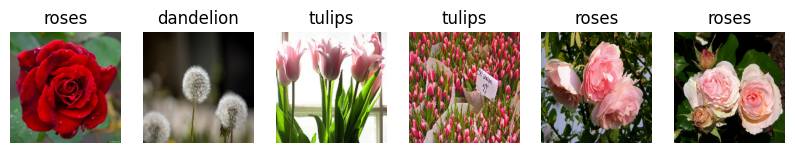

In [10]:
plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):
  tensor_images, tensor_labels = images, labels # save images/labels for 3.1
  for i in range(6):
    plt.subplot(1, 6, i + 1)
    plot_images(images[i].numpy().astype("uint8"), class_names[labels[i]])

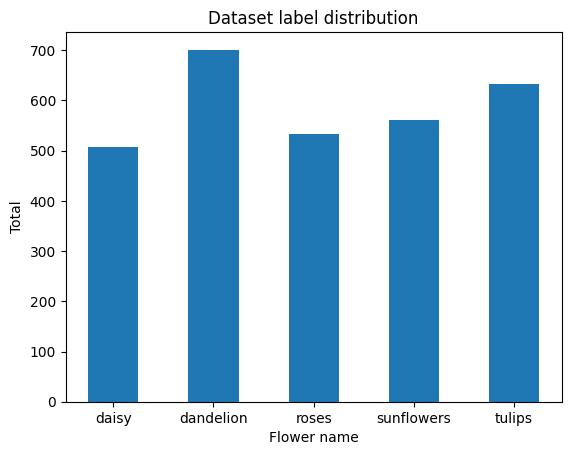

In [11]:
plot_distribution(train_ds, class_names)

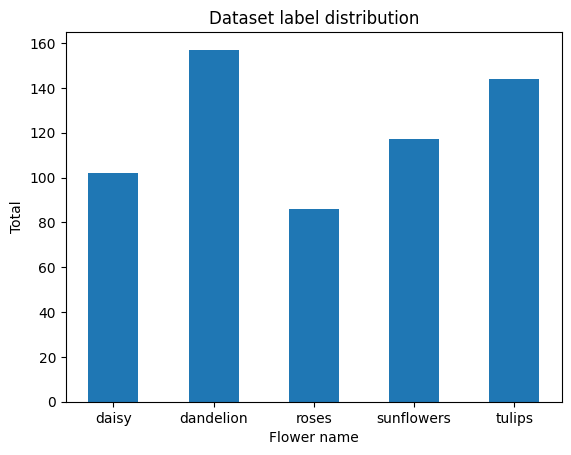

In [12]:
plot_distribution(val_ds, class_names)

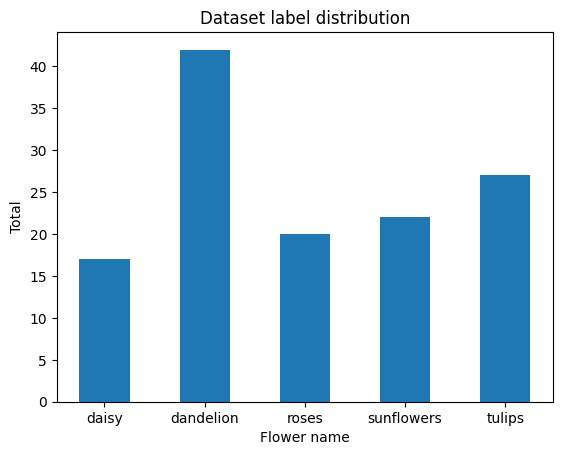

In [13]:
plot_distribution(test_ds, class_names)

The classes in the training set are unbalanced: there is a majority of dandelions (yellow flower head and papus). Data augmentation is performed to increase the number of data sets.

### 2.4. Data augmentation

The limited number of training elements given to the model doesn't lead to satisfactory performances. A risk of over-fitting is possible. The graph in section 3.4 shows a poor generalization of performance. Realistic transformations (rotation, flip & zoom) are then applied to the training data to diversify the data set.

In [14]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = keras.layers.RandomFlip("horizontal")(inputs)
x = keras.layers.RandomRotation(0.1)(x)
outputs = keras.layers.RandomZoom(0.1)(x)

data_augmentation = keras.Model(inputs=inputs, outputs=outputs, name="data_augmentation_layer")

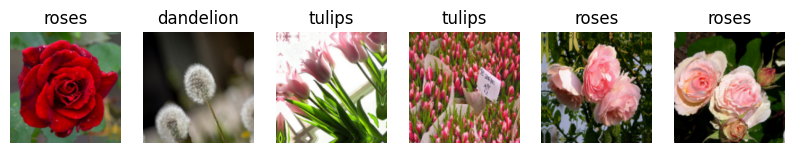

In [15]:
plt.figure(figsize=(10, 8))
images_modified = data_augmentation(tensor_images) # apply to the example set
for i in range(6):
  plt.subplot(1, 6, i + 1)
  plot_images(images_modified[i].numpy().astype("uint8"), class_names[tensor_labels[i]])

---


## **3. Model creation**

### 3.1. MobileNet V2 as an extractor model

MobileNet V2 is one of the pre-trained models integrated into Keras. It has been trained on a subset of the ImagetNet, a labeled image database with 1000 classes.

Despite this large number of classes, there's no guarantee that MobileNet V2 has been trained with images of roses, daisies and other flowers during the training phase. Therefore, the MobileNet's classification model is removed and only the feature extraction model is kept. A custom classification model is attached to the output of Mobile Net V2 and trained from scratch.

To used MobileNet V2, inputs are pre-processed to conform to the input pixel value expected by MobileNet V2 [[2]](https://keras.io/api/applications/mobilenet/).

In [16]:
preprocess_layer = keras.applications.mobilenet_v2.preprocess_input # rescale: [0,255] --> [-1,1]

MobileNet V2 is imported from the `keras.applications` API with weights computed during the ImageNet training. Classification layers are removed (`include_top=False`). Input image size is specified.


In [17]:
img_size = (img_height, img_width)
img_shape = img_size + (3,) # add 3 input channels (=rgb code)
extractor_model = keras.applications.MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')

<ipython-input-17-aaff06bff94b>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  extractor_model = keras.applications.MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')


`extractor_model` is "frezze" in order to avoid updating its weights.

In [18]:
extractor_model.trainable = False

### 3.2. Main model creation

`extractor_model` is included in a larger model capable to pre-process inputs and classify them.

In [19]:
def create_model():
  inputs = keras.Input(shape=(img_height, img_width, 3))
  x = data_augmentation(inputs)                         # input pre-processing layer
  x = preprocess_layer(x)                               # input pre-processing layer
  x = extractor_model(x, training=False)                # MoibleNet V2 - output size = (5, 5, 1280)
  x = keras.layers.GlobalAveragePooling2D()(x)          # data flattening - output size = (, 1280)
  x = keras.layers.Dropout(0.2)(x)
  outputs = keras.layers.Dense(5)(x)                    # output size = (, 5) - logit score
  model = keras.Model(inputs, outputs)

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

  return model

### 3.3. Model training

At the output of the model, there are 5 logit scores. The loss function `SparseCategoricalCrossentropy` is used (`from_logits=True`).

In [20]:
def train_model(model, training_data, validation_data, **kwargs):
  kwargs.setdefault("epochs", 5)
  kwargs.setdefault("verbose", 1)
  log = model.fit(training_data, validation_data=validation_data, validation_freq=1, **kwargs)

  return log.history["loss"], log.history["sparse_categorical_accuracy"], log.history["val_loss"], log.history["val_sparse_categorical_accuracy"]

The main model has 2.2 million parameters that are not updated (because they are frozen in section 3.1) and around 6,400 parameters from the classification model that are updated.  This training phase is fast, despite the complexity of the main model.

In [21]:
base_learning_rate = 0.0001
epochs = 10

if training_phase == "Yes":
  model = create_model()
  classifier_accuracy = train_model(model, train_ds, val_ds, epochs=epochs)
  model.save('05_transfert_learning.keras')
  print("Accuracy max %0.1f %% reached at the epoch %d" %(100*max(classifier_accuracy[3]), argmax(classifier_accuracy[3])+1))

Cloning into 'TensorFlow_duplicata'...
remote: Enumerating objects: 634, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 634 (delta 187), reused 94 (delta 94), pack-reused 368 (from 1)
Receiving objects: 100% (634/634), 169.37 MiB | 21.60 MiB/s, done.
Resolving deltas: 100% (314/314), done.


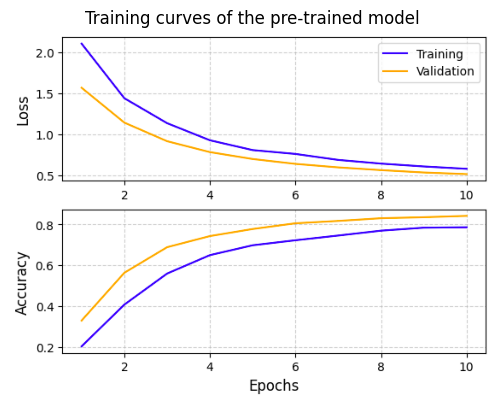

In [22]:
if training_phase == 'Yes':
  plot_evolution(classifier_accuracy)
else:
  training_curves_1, training_curves_2, model, model_FT = get_github_files()
  plt.imshow(training_curves_1), plt.title("Training curves of the pre-trained model"), plt.axis("off")

### 3.4. Evaluation


In [23]:
def get_predictions(dataset):
  loss_test, accuracy_test = model.evaluate(dataset, verbose=0)
  predictions = model.predict(dataset, verbose=0)
  print("Test loss value: %0.1f \nTest accuracy: %0.1f %%" %(loss_test, 100*accuracy_test))
  return predictions

In [24]:
predictions = get_predictions(test_ds)

Test loss value: 0.5 
Test accuracy: 82.8 %


The accuracy of the test set obtained is significantly higher to that obtained in the previous model (see 04_convolution_CNN.ipynb). This increase of 8% is notably due to the complexity of the extraction model used as input to the classification model.

Extending training to other epochs would not bring a significant gain in accuracy to the model, since the training and validation curves start to stagnate at the 10th epoch.

---


## **4. Fine tuning**

### 4.1. "Defrosted" model extractor

In order to increase model's performances, some layers of the model MobileNet V2 are unfrozen. Parameters will be updated during training. MobileNet V2 has been trained on generic flower images and it would be preferable to train it on specific flower images (dataset flowers).

[[3]](https://www.tensorflow.org/tutorials/images/transfer_learning?hl=fr) recommends unfreezing only the first layers of the MobileNet model, and keeping the deeper layers of high-feature extractions frozen. The feature extraction model MobileNet V2 has 154 layers, 2/3 of which are unfrozen.

In [25]:
extractor_model.trainable = True

In [26]:
fine_tune_at = 100
for layer in extractor_model.layers[:fine_tune_at]:
  layer.trainable = False

### 4.2. Training phase

To prevent the model from overfitting rapidly, the learning rate must be smaller than the previous training phase.

In [27]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [28]:
fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs

if training_phase == "Yes":
  classifier_accuracy_FT = train_model(model, train_ds, val_ds, epochs=fine_tune_epochs)
  model.save('05_transfert_learning_FT.keras')
  print("Accuracy max %0.1f %% reached at the epoch %d" %(100*max(classifier_accuracy_FT[3]), np.argmax(classifier_accuracy_FT[3])+1))

### 4.3. Evaluation

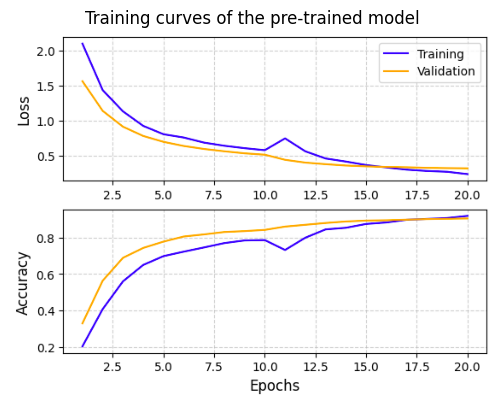

In [29]:
if training_phase == 'Yes':
  plot_evolution(tf.concat([classifier_accuracy, classifier_accuracy_FT], 1))
else:
  model = model_FT
  plt.imshow(training_curves_2), plt.title("Training curves of the pre-trained model"), plt.axis("off")

In [30]:
predictions = get_predictions(test_ds)

Test loss value: 0.3 
Test accuracy: 89.8 %


############################
Evaluation on the test set: 
############################
Accuracy...0.8984
Recall.....0.8984
F1-score...0.8993


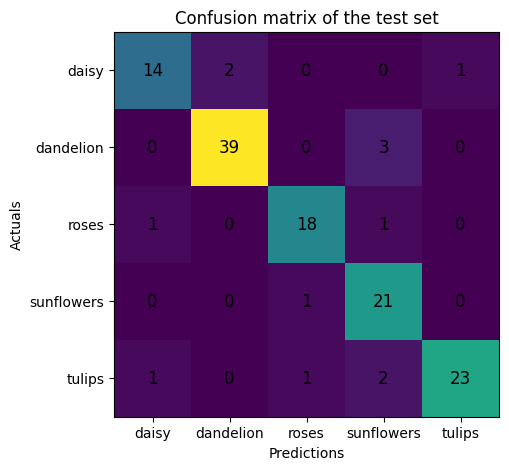

In [31]:
plot_evaluation(test_ds, predictions, class_names)

In [32]:
def get_worst_top(probabilities, y_test, x_test, rate):
  y_test_predicted = np.argmax(probabilities, axis=1)
  errors = (y_test_predicted - y_test != 0) # collects indexes of incorrect predictions
  y_predicted_error = y_test_predicted[errors] # mispredicted labels
  error_number = len(y_predicted_error)
  y_test_error = y_test[errors] # true labels

  y_predicted_error_probabilities = probabilities[errors]
  x_test_error = x_test[errors] # get images of mispredicted labels

  y_predicted_error_probability = np.max(y_predicted_error_probabilities, axis = 1) # get probabilities that led to errors
  y_test_error_probability = np.diagonal(np.take(y_predicted_error_probabilities, y_test_error, axis=1)) # get probabilities of a true values in the error set

  delta_errors = y_predicted_error_probability - y_test_error_probability
  delta_errors = np.argsort(delta_errors)
  top_errors = delta_errors[-int(rate*error_number):]
  print("%0.0f/%0.0f images belong to the top %0.0f-errors" %(len(top_errors), error_number, len(top_errors)))

  return top_errors, x_test_error, y_predicted_error, y_test_error

9/13 images belong to the top 9-errors


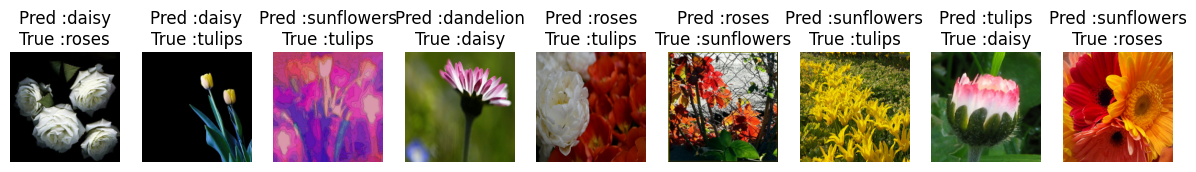

In [33]:
error_rate = 0.75

x_test = tf.concat([x for x, y in test_ds], axis=0)
y_test = tf.concat([y for x, y in test_ds], axis=0)

top_errors, x_test_error, y_predicted_error, y_test_error = get_worst_top(predictions, y_test, x_test, error_rate)
plot_errors(top_errors, x_test_error, y_predicted_error, y_test_error, class_names)

**The accuracy achieved on the test set (90%) is better with a pre-trained model used to extract complex features than that obtained by a simple sequential model composed of convolution layers (75%) (see: *04_convolution_CNN.ipynb*). Classification errors between roses and tulips have disappeared. Dandelions can still be confused with sunflowers. The f1-score indicates that the model is able to distinguish between classes.**

---


## **5. Predictions**

In [34]:
tulip, rose, daisy, sunflowers, bouquet = get_github_photo()

Cloning into 'TensorFlow_duplicata'...
remote: Enumerating objects: 634, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 634 (delta 187), reused 94 (delta 94), pack-reused 368 (from 1)
Receiving objects: 100% (634/634), 169.37 MiB | 22.76 MiB/s, done.
Resolving deltas: 100% (314/314), done.


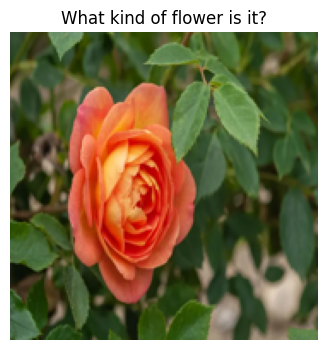

In [35]:
img = rose
img = Image.fromarray(np.array(img))
resized_img = img.resize((img_height, img_width))
plt.figure(figsize=(4, 4))
plt.imshow(resized_img), plt.title("What kind of flower is it?"), plt.axis("off")
plt.show()

In [36]:
resized_img_array = tf.expand_dims(np.array(resized_img), 0)
predictions = model.predict(resized_img_array)
score = tf.nn.softmax(predictions[0])

df = DataFrame(data={'class_names': class_names, 'score': 100*score.numpy()})
print(df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
  class_names      score
0       daisy   0.000048
1   dandelion   0.000653
2       roses  99.272667
3  sunflowers   0.007233
4      tulips   0.719402


---


## **6. References**


| | | | | |
|------|------|------|------|------|
| Index | Title | Author(s) | Type | Comments |
|[[1]](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition) | Flowers Recognition | Alexander Mamaev | dataset | - |
|[[2]](https://keras.io/api/applications/mobilenet/) | MobileNet, MobileNetV2, and MobileNetV3 | Keras | Tutoriels | - |
|[[3]](https://www.tensorflow.org/tutorials/images/transfer_learning?hl=fr) | Transfer learning and fine-tuning  | TensorFlow | Tutoriels | - |
|[[4]](https://arxiv.org/abs/1704.04861) | MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications | Andrew G. Howard and al. | paper | - |